Train validation data with convnet

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

In [55]:
data[data['ptl_idx']==1].head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0


In [56]:
test_data = data[data['ptl_idx']==1]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


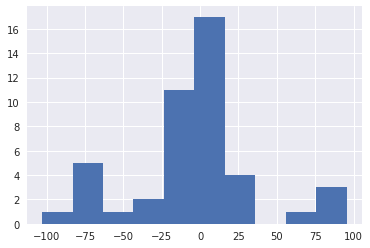

In [57]:
test_data['dt1'].hist()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


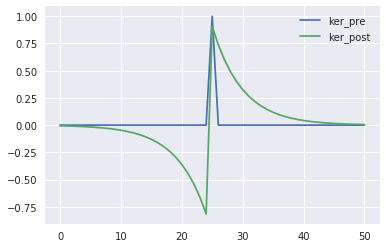

In [58]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()
plt.plot(ker_test.dot_ker, label='ker_pre')
plt.plot(ker_test.bilat_ker, label='ker_post')
plt.legend()

In [60]:
# Generate data
spk_pairs, targets = arb_w_gen(df=data, ptl_list=[1,2,3,4], kernel=ker_test, aug_times=10)

In [70]:
# Create the network
ground_truth_init = 0
toy_data_net = network.PairNet(kernel=ker_test, kernel_pre=ker_test.dot_ker, kernel_post=ker_test.bilat_ker, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])

In [71]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/PairNet_ptl1-4_toy'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [72]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

0.0

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


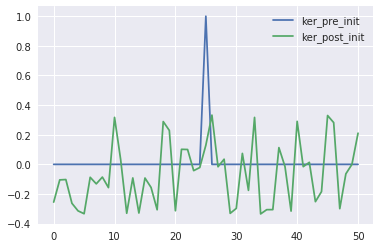

In [73]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(w_pre, label='ker_pre_init')
plt.plot(w_post, label='ker_post_init')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.legend()
bias

In [ ]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 3
min_error = 0.0000001
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3


Initial validation cost=308.11481
Global Step 0200 and Step 0200: validation cost=100.61570
Updated min validation loss!Saving model...
Global Step 0400 and Step 0400: validation cost=44.85865
Updated min validation loss!Saving model...
Global Step 0600 and Step 0600: validation cost=20.65164
Updated min validation loss!Saving model...
Global Step 0800 and Step 0800: validation cost=9.52350
Updated min validation loss!Saving model...
Global Step 1000 and Step 1000: validation cost=4.12264
Updated min validation loss!Saving model...
Global Step 1200 and Step 1200: validation cost=2.30005
Updated min validation loss!Saving model...
Global Step 1400 and Step 1400: validation cost=1.28440
Updated min validation loss!Saving model...
Global Step 1600 and Step 1600: validation cost=0.76946
Updated min validation loss!Saving model...
Global Step 1800 and Step 1800: validation cost=0.56172
Updated min validation loss!Saving model...
Global Step 2000 and Step 2000: validation cost=0.29327
Updat

bias = -0.0009570812107995152


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


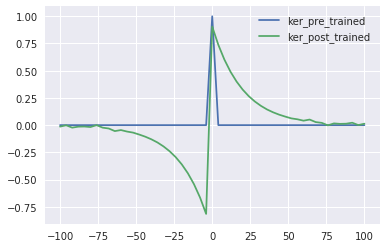

In [52]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(np.linspace(0,100,51)*2 - 100, w_pre,  label='ker_pre_trained')
plt.plot(np.linspace(0,100,51)*2 - 100, w_post,  label='ker_post_trained')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.legend()
print("bias = {bias}".format(bias=bias))